# Fidibo insights

### calculate diffrence in book price

In [6]:
import pandas as pd
import numpy as np

data = pd.read_csv('fidibo_books.csv')
data['price_diff'] = data['paper_price'] - data['price']
data=data.replace('NaN',np.nan)
data.head()

,title,price,paper_price,isbn,rating,page,publisher,price_diff
0,انسان در جستجوی معنی,8000,15000.0,9789646104266,4.38,255.0,انتشارات درسا,7000.0
1,مردی به نام اوه,8500,24500.0,9786007141779,4.34,392.0,نشر نون,16000.0
2,درنگ نکن انجامش بده,12000,20000.0,9786005253139,4.15,97.0,انتشارات سیته,8000.0
3,سیزده دلیل برای اینکه,5900,NaN,NaN,3.74,300.0,ناشرمولف,NaN
4,تاریخ ایران مدرن,15000,25000.0,9789641851264,4.64,352.0,نشر نی,10000.0


### histogram plots for columns

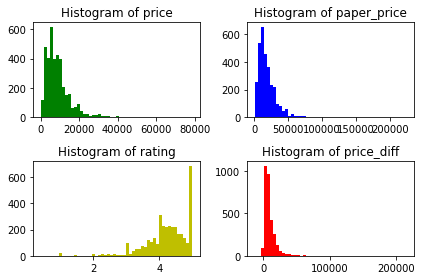

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(2, 2, 1)
plt.hist(data['price'], 50, facecolor='g')
plt.title('Histogram of price')
plt.subplot(2, 2, 2)
plt.hist(data['paper_price'], 50, facecolor='b')
plt.title('Histogram of paper_price')
plt.subplot(2, 2, 3)
plt.hist(data['rating'], 50, facecolor='y')
plt.title('Histogram of rating')
plt.subplot(2, 2, 4)
plt.hist(data['price_diff'], 50, facecolor='r')
plt.title('Histogram of price_diff')
plt.tight_layout()
plt.savefig('hists.png')
plt.show()


apparently all data columns have some points out of range but are not an outlier.
but a rating histogram point is too high so we need to investigate this plot more:

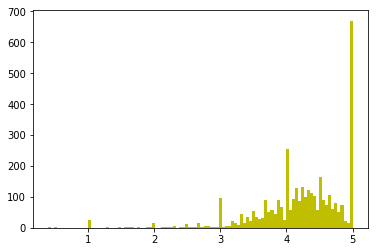

In [8]:
plt.hist(data['rating'], 100, facecolor='y')
plt.savefig('rating_hist.png')
plt.show()

In [9]:
rating = data[data['rating'] == 5]
rating.head()

,title,price,paper_price,isbn,rating,page,publisher,price_diff
67,چای نعنا,15000,25000.0,۹۷۸۶۰۰۸۴۸۲۰۷۹,5.0,168.0,نشر مثلث,10000.0
70,هری‌پاتر و زندانی آزکابان,25000,31000.0,9789645757012,5.0,496.0,انتشارات کتابسرای تندیس,6000.0
365,ماتریکس الهی,12500,25000.0,9786006721309,5.0,264.0,نشر نامک,12500.0
372,آن‌سوی اتهام,15000,NaN,9643126226,5.0,288.0,نشر نی,NaN
388,طریق شاهان,15000,35000.0,9786006225845,5.0,632.0,آذرباد,20000.0


so about 700 data rows are 5, it might be because fidibo ratings has a default value of 5
but after checking these rows they are fine and it's not default value.

### finding relationship between columns

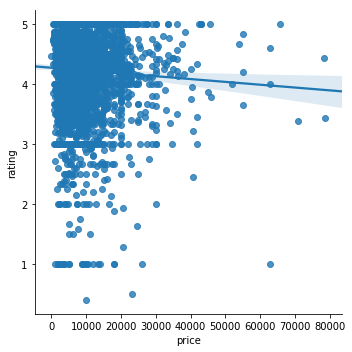

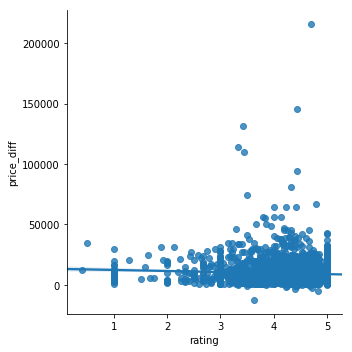

In [10]:
sns.lmplot(x="price", y="rating", data=data)
plt.show()
sns.lmplot(x="rating", y="price_diff", data=data)
plt.show()

no pattern in these two plot... next we should check its columns correlation
### columns correlation

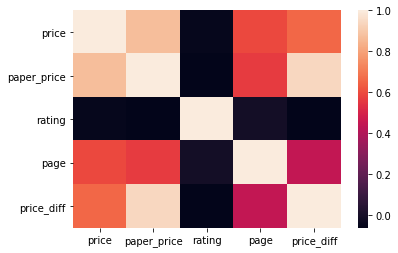

In [11]:
corr = data.corr()
sns.heatmap(corr)
plt.savefig('corr.png')
plt.show()

obviously paper price and price have high correlation but the intresting part is correlation between (price diff,price) and (price diff,paper price). paper price has more corr with price diff this shows that fidibo tries to balance prices in a way that higher paper price have more price diff. another thing to notice is that page has corr with price which is reasonable.

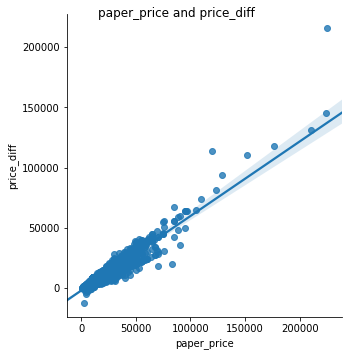

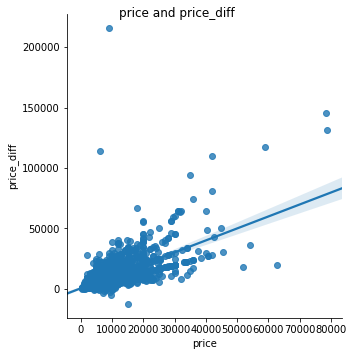

In [19]:

lm1 = sns.lmplot(x="paper_price", y="price_diff", data=data)
fig1 = lm1.fig 
fig1.suptitle("paper_price and price_diff")
plt.savefig('pp and pd.png')

lm2 = sns.lmplot(x="price", y="price_diff", data=data)
fig2 = lm2.fig 
fig2.suptitle('price and price_diff')
plt.savefig('p and pd.png')
plt.show()

## Model data to estimate price
### LASSO
one thing that we can do is to estimate price of books by lasso regression or use pca to do a feature melting

In [36]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = data["price"]
X = data.iloc[:,[2,4,5]]
X['paper_price'] = X['paper_price']/100
X['rating'] = X['rating']*100
X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train,y_train)


print(clf.intercept_) 
print(clf.coef_)
y_pred = clf.predict(X_test) 
test_lasso_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
accuracy = clf.score(X_test,y_test)
print(accuracy*100,'%')

1515.6106895657686
[30.61701954 -2.54773962 10.74892275]
66.62684445814644 %


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [39]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

y = data["price"]
X = data.iloc[:,[2,4,5]]
X['paper_price'] = X['paper_price']/100
X['rating'] = X['rating']*100
X = X.fillna(X.mean())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

pca=PCA(n_components=2) 
X_train = pca.fit(X_train) 
X_test=pca.transform(X_test) 
pca.explained_variance_ratio_  

   paper_price  rating   page
0   150.000000   438.0  255.0
1   245.000000   434.0  392.0
2   200.000000   415.0   97.0
3   188.699219   374.0  300.0
4   250.000000   464.0  352.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


array([0.70746281, 0.218839  ])

It can be seen that first principal component is responsible for 70% of our model so it's safe to convert it to one component

In [37]:
y = data["price"]
X = data.iloc[:,[2,4,5]]
X['paper_price'] = X['paper_price']/100
X['rating'] = X['rating']*100
X = X.fillna(X.mean())
X.head()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
pca=PCA(n_components=1) 
pca.fit(X_train) 
X_train=pca.transform(X_train) 
X_test=pca.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Regression 

8888.230972865651
[25.22520831]
59.16127391905792 %


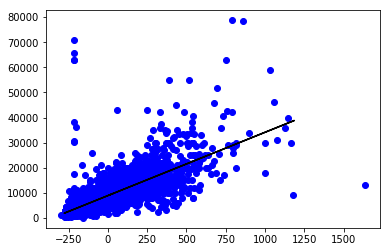

In [38]:
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
print(regressor.intercept_) 
print(regressor.coef_)
y_pred = regressor.predict(X_test) 
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
accuracy = regressor.score(X_test,y_test)
print(accuracy*100,'%')
plt.scatter(X_train, y_train,color='b')
plt.plot(X_test, y_pred,color='k')
plt.savefig('result_reg.png')
plt.show()


good :)

## Publishers correlation with the price and more

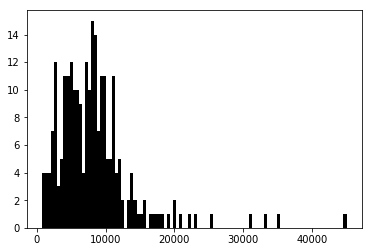

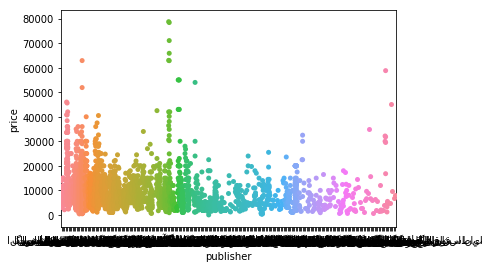

In [25]:
publishers_data =  data.groupby('publisher').agg({'price': 'mean'})
plt.hist(publishers_data['price'], 100, facecolor='k')
plt.show()
sns.swarmplot(x='publisher',y='price',data=data)
plt.show()

some publishers' books are more expensive than usual let's see what they are

In [26]:
expensive_publishers = publishers_data[publishers_data['price']>25000]
expensive_publishers


,price
publisher,
انتشارات سنجش و دانش,33180.000000
فیدیبو,30931.774194
موسسه فرهنگی هنری سانازسانيا,45000.000000
نشر بارسا,35000.000000
نشر تیر,25333.333333


these are expensive publishers...
what came to my mind is to add publishers data to our regression model so let's see how many publisher we have


In [27]:
data.drop_duplicates(subset=['publisher'], keep=False).shape

(64, 8)

we have 64 unique publisher (actually I excepted more) so it's a good Idea to include them (as dummy var) to our reg model

### pca regression

In [44]:
dum_data = pd.get_dummies(data.iloc[:,[2,4,5,6]], columns=['publisher'])
dum_data
# PCA and regression with publishers
y = data["price"]
X = dum_data
X['paper_price'] = X['paper_price']/100
X['rating'] = X['rating']*100
X = X.fillna(X.mean())
X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
pca=PCA(n_components=65) 
pca.fit(X_train) 
print(pca.explained_variance_ratio_)
X_train=pca.transform(X_train) 
X_test=pca.transform(X_test)


regressor1 = LinearRegression()  
regressor1.fit(X_train, y_train)
y_pred = regressor1.predict(X_test) 
w_publisher_test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
accuracy = regressor1.score(X_test,y_test)
print(accuracy*100,'%')
w_publisher_test_results


[7.07451106e-01 2.18835401e-01 7.36969831e-02 1.40285940e-06
 1.09263344e-06 6.22752412e-07 5.63284294e-07 4.83426361e-07
 4.51838097e-07 4.03549270e-07 3.44578576e-07 3.33346133e-07
 3.25167736e-07 3.22142558e-07 3.20567118e-07 3.18520062e-07
 3.03315113e-07 2.72548041e-07 2.59822123e-07 2.47792189e-07
 2.33815270e-07 2.24571185e-07 2.17239209e-07 2.07547880e-07
 1.95381103e-07 1.89343484e-07 1.83064039e-07 1.77168678e-07
 1.73012904e-07 1.69269743e-07 1.60974636e-07 1.52198046e-07
 1.48756062e-07 1.41584548e-07 1.37949046e-07 1.35083593e-07
 1.31931591e-07 1.26825729e-07 1.23552770e-07 1.20240998e-07
 1.14545711e-07 1.12447815e-07 1.04878630e-07 9.83501294e-08
 9.31072594e-08 8.41801070e-08 8.28035532e-08 7.87462456e-08
 7.85961698e-08 7.82452235e-08 7.78294023e-08 7.51112457e-08
 7.30464805e-08 7.28695383e-08 7.25191160e-08 6.95036818e-08
 6.69540848e-08 6.66649498e-08 6.61930425e-08 6.25891971e-08
 6.10092345e-08 6.02753202e-08 5.88186553e-08 5.81308675e-08
 5.58328932e-08]
76.1795

,Actual,Predicted
666,10200,6568.825518
314,4200,5666.863137
1372,2900,2245.392968
3165,10200,8315.203869
1703,2000,2023.520302
1320,6750,6532.050952
3026,3900,3027.047530
1105,6000,8992.448873
1346,9400,13758.851827
415,13500,12199.609642


### lasso regression

In [48]:
dum_data = pd.get_dummies(data.iloc[:,[2,s5,6]], columns=['publisher'])
dum_data
# PCA and regression with publishers
y = data["price"]
X = dum_data
X['paper_price'] = X['paper_price']/100
X = X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train,y_train)


y_pred = clf.predict(X_test) 
test_lasso_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
accuracy = clf.score(X_test,y_test)
print(accuracy*100,'%')


76.83962382416497 %
